# Diffusion Mnist

Welcome to this exciting project on Diffusion Models using the MNIST dataset! 🚀  
In this notebook, we will implement an **Autoencoder** with Convolutional Attention Blocks (CABs) to encode and decode MNIST digits, aiming to learn efficient latent representations.  
Let's dive into the process of building, training, and visualizing the model!  


## Autoencoder and Latent Creation

### Installing_Dependencies

To get started, let's install the necessary Python libraries for our diffusion model and autoencoder implementation. This includes PyTorch, torchvision for MNIST datasets, and visualization tools like matplotlib.  


In [3]:
# Install required libraries
!pip install torch torchvision einops matplotlib tqdm torchsummary torchviz


In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from einops import rearrange
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
from torchsummary import summary
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from torchviz import make_dot


### Dataset and DataLoader

We are using the MNIST dataset, which contains 28x28 grayscale images of handwritten digits (0-9).  
The `DataLoader` helps in batching, shuffling, and loading the data efficiently during training.  


In [5]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

### Channel Attention Layer (CALayer)


The **Channel Attention Block (CAB)** helps the autoencoder focus on essential parts of the feature map by applying attention mechanisms.  
- **Global Average Pooling** reduces spatial dimensions and generates a channel descriptor.  
- Two `Conv2d` layers reduce and then restore the channel dimensions, highlighting the most important features.  
- A `Sigmoid` activation generates attention weights, which are multiplied by the input feature map to emphasize critical channels.  

In [6]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16, bias=False):
        super(CALayer, self).__init__()
        # global average pooling: feature --> point
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # feature channel downscale and upscale --> channel weight
        self.conv_du = nn.Sequential(
            nn.Conv2d(channel, channel // reduction, 1, padding=0, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel // reduction, channel, 1, padding=0, bias=bias),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv_du(y)
        return x * y



### Convolutional Attention Block (CAB)


The CAB block applies convolution operations, followed by attention to refine features. This forms the core building block of our encoder and decoder layers.  
- **Conv2D** layers extract features.  
- **ReLU** applies non-linearity.  
- **Residual Connection** ensures that the input is preserved, aiding in gradient flow.  


In [ ]:
class CAB(nn.Module):
    def __init__(self, n_feat, reduction=16, bias=False):
        super(CAB, self).__init__()
        self.body = nn.Sequential(
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_feat, n_feat, 3, padding=1, bias=bias),
        )
        self.ca = CALayer(n_feat, reduction, bias=bias)

    def forward(self, x):
        res = self.body(x)
        res = self.ca(res)
        return res + x  # Residual Connection


## Encoder and Decoder


The encoder compresses the input into a latent representation (dimensional bottleneck), while the decoder reconstructs the image from the latent space.  
- The **Encoder** uses downsampling with strided convolutions and CAB blocks.  
- The **Decoder** performs upsampling using transposed convolutions (deconvolution).  
- A `linear` layer transforms the latent representation into feature maps during decoding.  

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.Conv2d(in_ch, out_ch, 3, stride=2, padding=1))
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels[-1] * 7 * 7, latent_dim),
        )

    def forward(self, x):
        if Config.DEBUG:
            print(f"Encoder Input Shape: {x.shape}")
        x = self.conv_layers(x)
        if Config.DEBUG:
            print(f"Encoder After Conv Layers: {x.shape}")
        x = self.flatten(x)
        if Config.DEBUG:
            print(f"Encoder Output (Flattened): {x.shape}")
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim, channels, num_cabs_per_layer):
        super().__init__()
        self.channels = channels  # Save channels as a class attribute

        # Define the linear layer for latent-to-feature map transformation
        self.linear = nn.Linear(latent_dim, channels[0] * 7 * 7)


        layers = []
        for in_ch, out_ch, num_cabs in zip(channels[:-1], channels[1:], num_cabs_per_layer):
            layers.append(nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1))  # Deconvolution layer
            layers.extend([CAB(out_ch, reduction=Config.REDUCTION_FACTOR) for _ in range(num_cabs)])  # Add CABs
            if out_ch != 1:  # Activation: ReLU for intermediate layers, Sigmoid for the final layer
                layers.append(nn.ReLU())
            else:
                layers.append(nn.Sigmoid())

        self.deconv_layers = nn.Sequential(*layers)

    def forward(self, z):
        if Config.DEBUG:
            print(f"Decoder Input Shape: {z.shape}")

        # Latent to feature map
        x = self.linear(z)
        if Config.DEBUG:
            print(f"After Linear Layer: {x.shape} (Expected: [batch_size, {self.channels[0] * 7 * 7}])")

        x = rearrange(x, "b (c h w) -> b c h w", c=self.channels[0], h=7, w=7)
        if Config.DEBUG:
            print(f"After Reshape: {x.shape} (Expected: [batch_size, {self.channels[0]}, 7, 7])")

        # Pass through the deconvolution layers
        x = self.deconv_layers(x)
        if Config.DEBUG:
            print(f"Decoder Output Shape: {x.shape} (Expected: [batch_size, 1, 28, 28])")

        return x


### Autoencoder Architecture  

The `Autoencoder` class integrates the encoder and decoder components.  
- The `encode` method compresses input data into a latent representation.  
- The `decode` method reconstructs the input from the latent space.  
- The `forward` method orchestrates the encoding and decoding processes during training and inference.  
Debugging outputs are available if `Config.DEBUG` is set to `True`, allowing visibility into input/output shapes at each step.  


In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.encoder = Encoder(latent_dim, Config.ENCODER_CHANNELS, Config.NUM_CABS_ENCODER)
        self.decoder = Decoder(latent_dim, Config.DECODER_CHANNELS, Config.NUM_CABS_DECODER)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        if Config.DEBUG:
            print(f"Autoencoder Input Shape: {x.shape}")
        z = self.encoder(x)
        if Config.DEBUG:
            print(f"Latent Representation Shape: {z.shape}")
        out = self.decoder(z)
        if Config.DEBUG:
            print(f"Autoencoder Output Shape: {out.shape}")
        return out


### Training

### Training Loop for Autoencoder  


The `train_autoencoder` function handles the entire training process:  
1. **Data Loading:** MNIST training data is loaded using the `DataLoader`.  
2. **Model Initialization:** The autoencoder is instantiated and transferred to the appropriate device (CPU/GPU).  
3. **Loss and Optimizer:** MSE (Mean Squared Error) loss is used to measure the reconstruction quality, while the Adam optimizer updates weights.  
4. **Training Progress:** The model iterates through multiple epochs, updating the weights using backpropagation. Loss values are recorded and displayed after each epoch.  
5. **Model Saving:** The trained model is saved for future inference.  
6. **Visualization:** A loss curve is plotted to monitor convergence and performance improvement across epochs.  

In [9]:
def train_autoencoder():
    # Load data
    train_loader = get_mnist_dataloader(train=True)

    # Initialize model, loss, and optimizer
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    summary(autoencoder, input_size=(1, Config.IMAGE_SIZE, Config.IMAGE_SIZE))

    # Visualize the model architecture
    dummy_input = torch.randn(1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(Config.DEVICE)
    dummy_output = autoencoder(dummy_input)
    dot = make_dot(dummy_output, params=dict(autoencoder.named_parameters()))
    dot.render(os.path.join(Config.SAVE_DIR, "autoencoder_architecture"), format="png")
    print(f"Model architecture visualization saved to {Config.SAVE_DIR}/autoencoder_architecture.png")

    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=Config.LR)

    loss_history = []
    # Training loop
    autoencoder.train()
    for epoch in range(Config.EPOCHS):
        epoch_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{Config.EPOCHS}")
        for images, _ in pbar:
            images = images.to(Config.DEVICE)
            # Forward pass
            recon_images = autoencoder(images)
            loss = criterion(recon_images, images)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss
            epoch_loss += loss.item()
            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

        average_loss = epoch_loss / len(train_loader)
        loss_history.append(average_loss)
        print(f"Epoch {epoch + 1}: Average Loss: {average_loss:.4f}")

    # Save the trained model
    save_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    torch.save(autoencoder.state_dict(), save_path)
    print(f"Autoencoder training completed and model saved at: {save_path}")

    # Plot the loss curve
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Config.EPOCHS + 1), loss_history, marker='o', label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [10]:
def train_model(model, dataloader):
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    for epoch in range(Config.EPOCHS):
        for images, _ in dataloader:
            images = images.to(Config.DEVICE)
            loss = model.training_step(images)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}/{Config.EPOCHS}, Loss: {loss.item()}")


In [11]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "Autoencoder_with_CAB.pth"
    BATCH_SIZE = 64
    EPOCHS = 10
    LR = 1e-4
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]         # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]         # Latent -> Intermediate -> Output
    NUM_CABS_ENCODER = [1, 0]              # Number of CABs in each encoder layer
    NUM_CABS_DECODER = [1, 0]              # Number of CABs in each decoder layer
    REDUCTION_FACTOR = 8                  # Channel attention reduction factor
    DEBUG = False                          # Enable debugging prints

In [17]:
os.makedirs(Config.SAVE_DIR, exist_ok=True)

In [4]:
#######

In [5]:
######## careful #######

In [ ]:
#######

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
            Conv2d-2           [-1, 16, 14, 14]           2,304
              ReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           2,304
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
            Conv2d-6              [-1, 2, 1, 1]              32
              ReLU-7              [-1, 2, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]              32
           Sigmoid-9             [-1, 16, 1, 1]               0
          CALayer-10           [-1, 16, 14, 14]               0
              CAB-11           [-1, 16, 14, 14]               0
             ReLU-12           [-1, 16, 14, 14]               0
           Conv2d-13        

Epoch 1/10: 100%|██████████| 938/938 [00:16<00:00, 56.07it/s, Loss=0.0325]


Epoch 1: Average Loss: 0.0633


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 57.94it/s, Loss=0.0146]


Epoch 2: Average Loss: 0.0199


Epoch 3/10: 100%|██████████| 938/938 [00:17<00:00, 54.92it/s, Loss=0.0125]


Epoch 3: Average Loss: 0.0141


Epoch 4/10: 100%|██████████| 938/938 [00:16<00:00, 57.75it/s, Loss=0.0091]


Epoch 4: Average Loss: 0.0108


Epoch 5/10: 100%|██████████| 938/938 [00:16<00:00, 57.62it/s, Loss=0.0073]


Epoch 5: Average Loss: 0.0085


Epoch 6/10: 100%|██████████| 938/938 [00:15<00:00, 58.67it/s, Loss=0.0067]


Epoch 6: Average Loss: 0.0067


Epoch 7/10: 100%|██████████| 938/938 [00:15<00:00, 59.19it/s, Loss=0.0060]


Epoch 7: Average Loss: 0.0058


Epoch 8/10: 100%|██████████| 938/938 [00:15<00:00, 59.12it/s, Loss=0.0046]


Epoch 8: Average Loss: 0.0052


Epoch 9/10: 100%|██████████| 938/938 [00:15<00:00, 59.47it/s, Loss=0.0044]


Epoch 9: Average Loss: 0.0048


Epoch 10/10: 100%|██████████| 938/938 [00:15<00:00, 59.02it/s, Loss=0.0053]


Epoch 10: Average Loss: 0.0045
Autoencoder training completed and model saved at: /content/drive/My Drive/AI/Projects/diffusion mnist/models/Autoencoder_with_CAB.pth


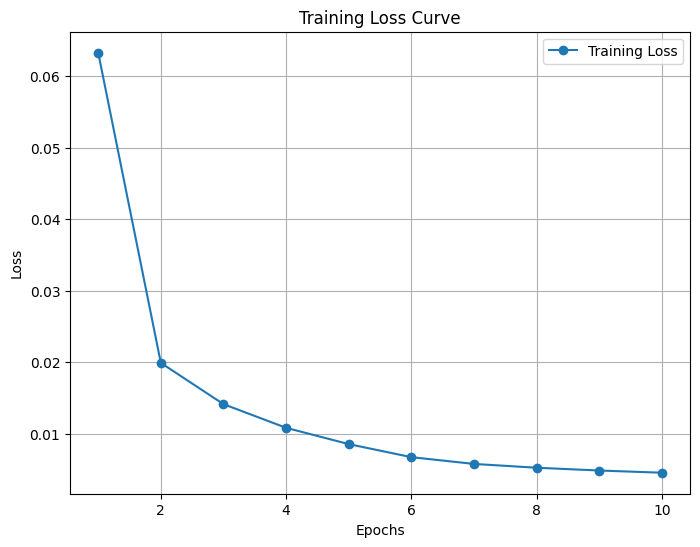

In [ ]:
train_autoencoder()


## Image Reconstruction and Performance Metrics

**Metrics Calculation:**  
   - **SSIM (Structural Similarity Index):** Measures the perceptual similarity between original and reconstructed images (1.0 indicates perfect similarity).  
   - **PSNR (Peak Signal-to-Noise Ratio):** Quantifies the quality of reconstructed images based on signal strength (higher is better).  


In [12]:
def calculate_metrics(original, reconstructed):
    original = original.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    ssim_scores = []
    psnr_scores = []

    for i in range(original.shape[0]):
        original_img = original[i, 0]
        reconstructed_img = reconstructed[i, 0]

        ssim_score = ssim(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())
        psnr_score = psnr(original_img, reconstructed_img, data_range=original_img.max() - original_img.min())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    return np.mean(ssim_scores), np.mean(psnr_scores)

In [13]:
def visualize_reconstructions():
    # Load the model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Get test data
    test_loader = get_mnist_dataloader(train=False)
    images, _ = next(iter(test_loader))
    images = images.to(Config.DEVICE)

    # Reconstruct
    with torch.no_grad():
        recon_images = autoencoder(images)

    # Calculate metrics
    avg_ssim, avg_psnr = calculate_metrics(images, recon_images)
    print(f"Average SSIM: {avg_ssim:.4f}, Average PSNR: {avg_psnr:.2f}")

    # Visualization
    num_images = 10
    fig, axes = plt.subplots(2, num_images, figsize=(18, 6))
    fig.suptitle(f"SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.2f}", fontsize=16, y=0.92)

    for i in range(num_images):
        original_img = images[i][0].cpu().numpy()
        reconstructed_img = recon_images[i][0].cpu().numpy()

        # Original images
        axes[0, i].imshow(original_img, cmap="gray")
        ssim_score = ssim(original_img, reconstructed_img, data_range=1.0)
        axes[0, i].set_title(f"Original", fontsize=10)
        axes[0, i].axis("off")

        # Reconstructed images
        axes[1, i].imshow(reconstructed_img, cmap="gray")
        axes[1, i].set_title(f"Reconstructed\nSSIM: {ssim_score:.2f}", fontsize=10)
        axes[1, i].axis("off")

    # plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()


In [20]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

<ipython-input-14-d7b8f594bd62>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


Average SSIM: 0.9586, Average PSNR: 24.94


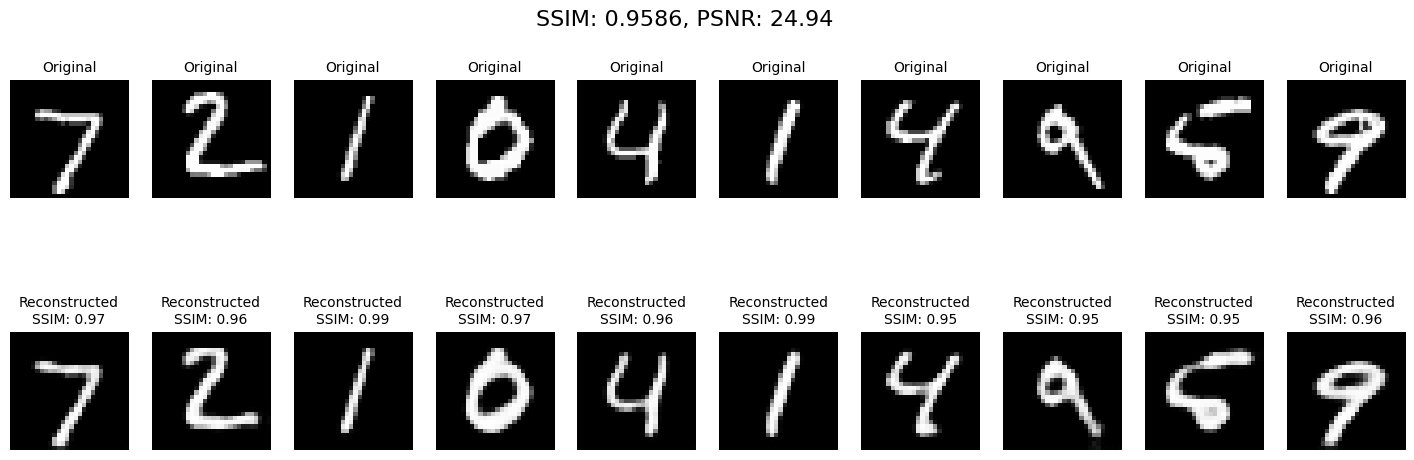

In [ ]:
visualize_reconstructions()



- Reconstructed images closely resemble the originals, showcasing minimal distortion.  
- The average SSIM (~ 0.96) and PSNR (~ 24.9 dB) indicate high fidelity in reconstruction, suggesting the autoencoder has effectively learned meaningful representations.

### 📌 **Latent Space Visualization**  



The `visualize_latent_space` function projects latent representations into a 2D plane using t-SNE (t-distributed Stochastic Neighbor Embedding).  
1. **Dimensionality Reduction:** t-SNE reduces high-dimensional latent vectors to two dimensions, facilitating visualization.  
2. **Scatter Plot:** Digits are color-coded, revealing cluster formation in latent space.  

In [14]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=True)
    images, labels = next(iter(test_loader))
    images = images.to(Config.DEVICE)
    labels = labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with labels
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(labels):
        plt.annotate(str(label), (latents_2d[i, 0], latents_2d[i, 1]),
                     textcoords="offset points", xytext=(0, 2), ha='center', fontsize=8, color='black')

    plt.title("Latent Space Visualization with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [15]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

In [ ]:
visualize_latent_space()

<ipython-input-19-19b3b8b4e12a>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)))


- Clear separation between clusters confirms that the autoencoder encodes distinct and informative latent representations.  
- Digits with similar structures (e.g., `1` and `7` or `0` and `8`) may exhibit slight overlap, suggesting areas for potential improvement in model expressiveness.  



In [16]:
def visualize_latent_space():
    # Load the trained model
    autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
    load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
    autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))
    autoencoder.eval()

    # Load the test data
    test_loader = get_mnist_dataloader(train=False)
    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(Config.DEVICE)
    test_labels = test_labels.cpu().numpy()  # Move labels to CPU for visualization

    # Encode the images to the latent space
    with torch.no_grad():
        latents = autoencoder.encode(test_images).cpu().numpy()

    # Reduce dimensions to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    # Create a scatter plot with annotations
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=test_labels, cmap="tab10", s=40, alpha=0.8)
    plt.colorbar(scatter, label="Digit Label")

    # Annotate each point with its digit label
    for i, label in enumerate(test_labels):
        plt.annotate(
            str(label),
            (latents_2d[i, 0], latents_2d[i, 1]),
            textcoords="offset points",
            xytext=(0, 2),
            ha="center",
            fontsize=8,
            color="black",
        )

    plt.title("Latent Space Visualization (Single Test Batch) with Labels", fontsize=16)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # # Entire training dataset
    # visualize_latent_space_full(
    #     autoencoder,
    #     get_mnist_dataloader(train=True),
    #     title="Latent Space Visualization (Entire Training Dataset)",
    #     save_path=os.path.join(Config.SAVE_DIR, "latent_space_train.png"),
    # )

    # Entire test dataset
    visualize_latent_space_full(
        autoencoder,
        test_loader,
        title="Latent Space Visualization (Entire Test Dataset)",
        save_path=os.path.join(Config.SAVE_DIR, "latent_space_test.png"),
    )


In [ ]:
#######

In [ ]:
######## careful #######

In [ ]:
#######

<ipython-input-23-e977b402ca11>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path, map_location=Config.DEVICE))


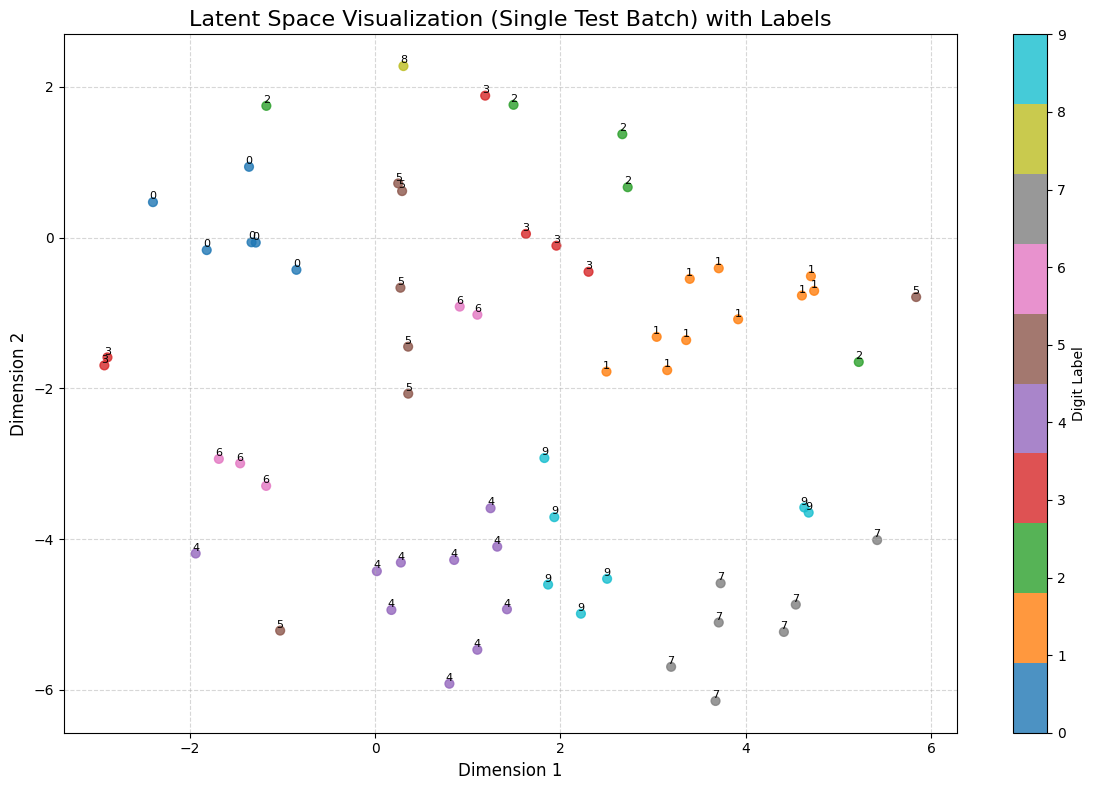

Encoding Latent Space Visualization (Entire Test Dataset): 100%|██████████| 157/157 [00:01<00:00, 128.60it/s]


Saved visualization to /content/drive/My Drive/AI/Projects/diffusion mnist/models/latent_space_test.png


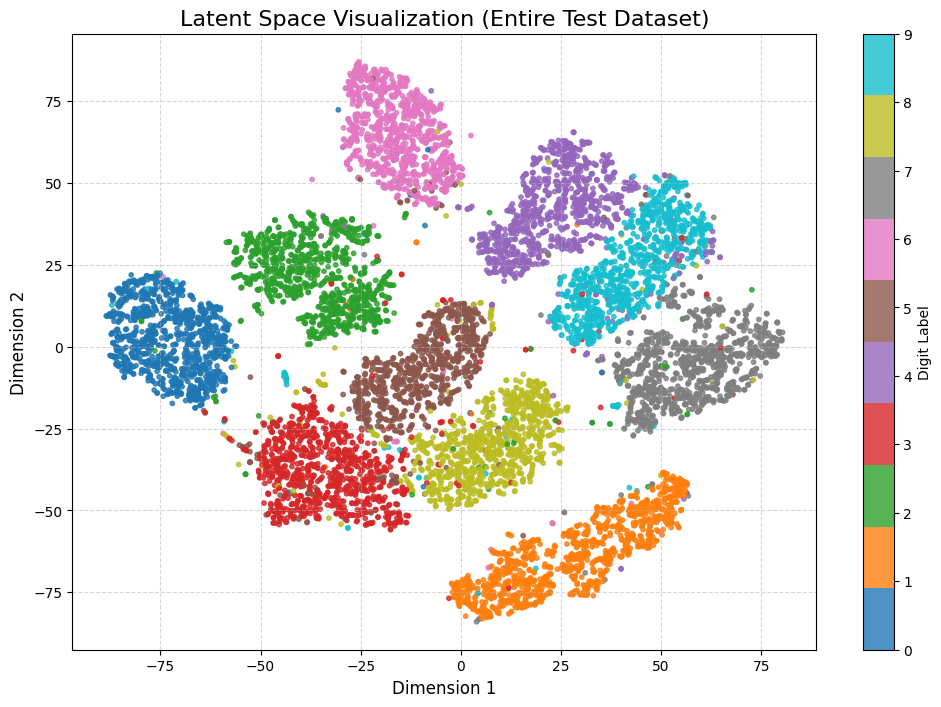

In [ ]:
visualize_latent_space()

- The full dataset visualization reveals clearer clusters, with minimal overlap between classes.  
- This indicates that the model effectively captures digit patterns and distributions across the dataset.  

## Denoising Diffusion Probabilistic Model Implementation

This section implements a **Denoising Diffusion Probabilistic Model (DDPM)**, which is a generative model capable of producing high-quality samples from complex data distributions.   
The model works by gradually adding noise to data through a forward diffusion process and then learning to reverse this process using a neural network (UNet).  

Key Components Implemented:  
- **Forward Diffusion (Noise Addition):** Adds noise to input data progressively over multiple timesteps.  
- **Reverse Diffusion (Denoising):** A neural network (UNet) predicts noise at each step to gradually reconstruct the original data.  
- **Training Objective:** The model minimizes the difference between predicted and actual noise using Mean Squared Error (MSE).  

This approach underpins modern generative models, making it essential in fields like image synthesis.  


In [17]:
import math
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from typing import Optional
import matplotlib.pyplot as plt
from torch.nn import functional as F


In [18]:
def get_transforms():
    return transforms.Compose([
        transforms.ToTensor(),
    ])

def get_mnist_dataloader(train=True):
    dataset = datasets.MNIST(
        root="./data", train=train, download=True, transform=get_transforms()
    )
    dataloader = DataLoader(dataset, batch_size=Config.BATCH_SIZE, shuffle=train)
    return dataloader

### Swish Activation Function  


The `Swish` activation function enhances non-linearity by allowing small negative values to pass through, improving network expressiveness.  


In [19]:
class Swish(nn.Module):
    """Swish activation function."""
    def forward(self, x):
        return x * torch.sigmoid(x)

### DenoiseDiffusion Class - Forward and Reverse Processes  


The `DenoiseDiffusion` class implements the key operations for the diffusion process:  
1. **Initialization (`__init__`):** Defines noise schedules (`beta` and `alpha`) across timesteps.  
2. **Gathering (`gather`):** Retrieves noise parameters at specific timesteps.  
3. **Forward Diffusion (`q_sample`):** Simulates the forward process by adding noise to latent representations at various timesteps.  
4. **Reverse Sampling (`p_sample`):** Reverses the noise process by predicting clean data from noised data using the learned network (`eps_model`).  
5. **Loss Calculation:** The objective is to minimize the difference between the predicted noise and the actual noise using MSE.  

**Noise Scheduling:**  
- Noise is gradually increased over 1000 steps, ensuring smooth transitions from data to pure noise.  
- The learned model reverses this process, progressively generating clean data from random noise.  

In [20]:
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model= eps_model
        self.beta= torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha= 1- self.beta
        self.alpha_bar= torch.cumprod(self.alpha, dim= 0)
        self.n_steps= n_steps
        self.sigma= self.beta

    def gather(self, const: torch.tensor, t: torch.tensor):
        # collecting elements of consts with dim= -1 according to t
        c= const.gather(dim= -1, index= t)
        return c.reshape(-1, 1, 1, 1)

    # compute maen and var of xt according to latent
    def q_xt_x0(self, latent: torch.tensor, t: torch.tensor):
        # xt= sqrt(at)* latent+ sqrt(1- at)* eps
        # return sqrt(at)* latent, 1- at
        mean_= self.gather(self.alpha_bar, t)** 0.5* latent
        var_= 1- self.gather(self.alpha_bar, t)
        return mean_, var_

    # forward-diffusion
    def q_sample(self, latent: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]= None):
        # compute xt according to latent
        if eps is None:
            eps= torch.randn_like(latent)
        mean_, var_= self.q_xt_x0(latent ,t)
        return mean_+ (var_** 0.5)* eps

    # sampling a pic
    def p_sample(self, xt: torch.tensor, t: torch.tensor):
        eps_hat= self.eps_model(xt, t)
        alpha_bar= self.gather(self.alpha_bar, t)
        alpha= self.gather(self.alpha, t)
        eps_coef= (1- alpha)/ (1- alpha_bar)** 0.5
        mean_= 1/ (alpha** 0.5)* (xt- eps_coef* eps_hat)
        var_= self.gather(self.sigma, t)
        eps= torch.randn(xt.shape, device= xt.device)
        return mean_+ (var_** 0.5)* eps

    # loss
    def loss(self, latent: torch.tensor, noise: Optional[torch.Tensor]= None):
        # print(f"Input to diffusion model (latent): {latent.shape}")  # Debug input shape
        batch_size= latent.shape[0]
        # (batch_size, )
        t= torch.randint(0, self.n_steps, (batch_size, ), device= latent.device, dtype= torch.long)
        # noise, (B, 4, H/ 4, W/ 4)
        if noise is None:noise= torch.randn_like(latent)
        # add noise
        xt= self.q_sample(latent, t, eps= noise)
        # print(f"Noised latent (xt): {xt.shape}")  # Debug noised latent shape
        # xt, (B, 4, H/ 4, W/ 4); t, (B, )
        eps_hat= self.eps_model(xt, t)
        # print(f"Predicted noise (eps_hat): {eps_hat.shape}")  # Debug predicted noise shape
        return F.mse_loss(noise, eps_hat)

### UNet_ResidualBlock - Core Building Block of UNet  


The `UNet_ResidualBlock` processes image features while preserving spatial information.  
It combines:  
- **Group Normalization (GN):** Stabilizes training by normalizing across feature groups.  
- **Convolutions:** Learn local patterns at each step.  
- **Time Embedding:** Injects time-dependent information into the residual block, critical for controlling diffusion across timesteps.  


In [21]:
class UNet_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_time=16, num_groups=8):
        """
        Residual block with time embedding.
        Args:
            in_channels: Input channels.
            out_channels: Output channels.
            d_time: Dimension of time embedding.
            num_groups: Number of groups for GroupNorm.
        """
        super().__init__()
        # print(f"[DEBUG] ResidualBlock initialized with in_channels={in_channels}, out_channels={out_channels}")

        # GroupNorm dynamically adjusts the number of groups
        self.gn_feat = nn.GroupNorm(min(num_groups, in_channels), in_channels)
        self.cv_feat = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.lin_time = nn.Linear(d_time, out_channels)
        self.gn_merged = nn.GroupNorm(min(num_groups, out_channels), out_channels)
        self.cv_merged = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Handle residual connection if channels mismatch
        self.residual_layer = (
            nn.Identity() if in_channels == out_channels
            else nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
        )

    def forward(self, feat, t):
        # print(f"[DEBUG] ResidualBlock forward: input shape={feat.shape}, time shape={t.shape}")
        residual = feat

        # First normalization and convolution
        feat = F.silu(self.gn_feat(feat))
        feat = F.silu(self.cv_feat(feat))

        # Add time embedding
        time_emb = self.lin_time(F.silu(t))
        # print(f"[DEBUG] Time embedding shape={time_emb.shape}")
        feat += time_emb[:, :, None, None]

        # Second normalization and convolution
        feat = F.silu(self.gn_merged(feat))
        feat = self.cv_merged(feat)

        # Add residual
        residual_out = self.residual_layer(residual)
        # print(f"[DEBUG] Residual shape={residual_out.shape}")
        # print(f"[DEBUG] Block output shape={feat.shape}")
        return feat + residual_out


### UNet_AttentionBlock - Incorporating Self-Attention  



This block introduces self-attention mechanisms into the UNet architecture.  

**Key Components:**  
- **Multi-head Attention:** Divides features into multiple heads, each attending to different parts of the input.  
- **Scaling:** Scales queries/keys by the square root of the embedding dimension to stabilize gradients.  
- **Residual Addition:** The original features are added back to the attention output to form residual connections, preserving essential information.  

**Why Attention?**  
Attention helps the model focus on important regions, allowing long-range dependencies to be captured, enhancing generative quality.  

In [22]:
class UNet_AttentionBlock(nn.Module):
    def __init__(self, n_channels: int, n_heads: int, n_dims: int = None, n_groups: int = 8):
        """
        Attention block.
        Args:
            n_channels: Number of channels.
            n_heads: Number of attention heads.
            n_dims: Dimensionality of attention embedding.
            n_groups: Groups for normalization.
        """
        super().__init__()
        if n_dims is None:
            n_dims = n_channels
        # print(f"[DEBUG] Initializing AttentionBlock: n_channels={n_channels}, n_heads={n_heads}, n_dims={n_dims}")
        self.gn = nn.GroupNorm(n_groups, n_channels)
        self.proj = nn.Linear(n_channels, n_dims * 3)  # Projection layer for Q, K, V
        self.output = nn.Linear(n_dims, n_channels)   # Output projection
        self.scale = n_dims ** -0.5
        self.n_heads = n_heads
        self.n_dims = n_dims

    def forward(self, x, t: Optional[torch.tensor] = None):
        _ = t  # Time embedding is unused in this attention block
        b, c, h, w = x.shape
        # print(f"[DEBUG] AttentionBlock forward: input x.shape={x.shape}, self.n_heads={self.n_heads}")

        # Check divisibility of channels by heads
        # if c % self.n_heads != 0:
        #     raise ValueError(
        #         f"Number of channels ({c}) must be divisible by the number of heads ({self.n_heads})."
        #     )

        # Save the original input for the residual connection
        x_original = x

        # Normalize input
        x = self.gn(x)  # GroupNorm across the channels

        # Flatten spatial dimensions
        x = x.view(b, c, h * w).permute(0, 2, 1)  # Shape: [B, H*W, C]
        # print(f"[DEBUG] After flattening and permuting: shape={x.shape}")

        # Project to Q, K, V
        proj = self.proj(x)  # Shape: [B, H*W, n_dims*3]
        # print(f"[DEBUG] After projection: shape={proj.shape}")

        # Split into Q, K, V and reshape for heads
        try:
            q, k, v = proj.reshape(b, h * w, self.n_heads, -1).chunk(3, dim=-1)
        except RuntimeError as e:
            # print(f"[DEBUG] Projection shape mismatch. Projection size: {proj.shape}")
            raise e

        # print(f"[DEBUG] q shape={q.shape}, k shape={k.shape}, v shape={v.shape}")

        # Compute attention
        att = torch.einsum("blhd,bmhd->blmh", q, k) / self.scale  # Scaled dot-product
        # print(f"[DEBUG] Attention matrix shape: {att.shape}")
        att = torch.softmax(att, dim=-2)  # Normalize across keys
        x = torch.einsum("blmh,bmhd->blhd", att, v)  # Weighted sum
        # print(f"[DEBUG] After attention computation: shape={x.shape}")

        # Reshape and output projection
        x = x.reshape(b, h * w, -1)  # Shape: [B, H*W, n_dims]
        x = self.output(x)  # Shape: [B, H*W, n_channels]
        # print(f"[DEBUG] After output projection: shape={x.shape}")

        # # Add the original input (residual connection)
        # x = x + x_original.view(b, c, h * w).permute(0, 2, 1)  # Match dimensions for addition
        # print(f"[DEBUG] After adding residual: shape={x.shape}")

        # Reshape back to [B, C, H, W]
        x = x.permute(0, 2, 1).reshape(b, c, h, w) + x_original
        # print(f"[DEBUG] After reshaping back: shape={x.shape}")
        return x


In [23]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, t):
        # print(f"[DEBUG] SwitchSequential: starting forward with input shape={x.shape}")
        for layer in self:
            layer_type = type(layer).__name__
            if isinstance(layer, (UNet_AttentionBlock, UNet_ResidualBlock)):
                # print(f"[DEBUG] Passing through {layer_type}")
                x = layer(x, t)
            else:
                # print(f"[DEBUG] Passing through non-time-embedded layer {layer_type}")
                x = layer(x)
        # print(f"[DEBUG] SwitchSequential: final output shape={x.shape}")
        return x

### Time Embedding for Temporal Control  



The `TimeEmbedding` class generates embeddings representing each timestep, allowing the model to understand how noise evolves across different diffusion steps.  

**Mechanism:**  
- **Positional Encoding (Sine/Cosine):** Provides periodic signals representing different timesteps.  
- **Swish Activation:** Enhances non-linearity in embedding projections.  


In [24]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int= 16):
        super().__init__()
        self.n_channels= n_channels
        self.lin1= nn.Linear(self.n_channels, self.n_channels)
        self.act= Swish()
        self.lin2= nn.Linear(self.n_channels, self.n_channels)
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 2
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1)
        return self.lin2(self.act(self.lin1(emb)))

### UNet Architecture - Backbone of DDPM  



The `UNet` class defines the architecture responsible for predicting noise during reverse diffusion.  

**Architecture Breakdown:**  
- **Encoder:**  
   - Downsampling layers progressively reduce spatial dimensions.  
   - Each stage consists of residual and attention blocks for feature extraction.  
- **Bottleneck:**  
   - Central part of the network that connects the encoder and decoder, incorporating attention mechanisms.  
- **Decoder:**  
   - Upsampling layers reconstruct the image by gradually increasing spatial dimensions.  
   - Skip connections transfer features from encoder layers to corresponding decoder layers, preserving details.  


In [25]:
class UNet(nn.Module):
    def __init__(self, input_channels, latent_shape):
        super().__init__()
        self.input_channels = input_channels
        self.latent_shape = latent_shape

        # Encoder: Downsampling Path with Residual and Attention
        self.encoder = nn.ModuleList([
            # Layer 1: Input -> 16 channels
            SwitchSequential(
                nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
                UNet_ResidualBlock(16, 16),
                UNet_ResidualBlock(16, 16)
            ),
            # Layer 2: 16 -> 32 channels with downsampling
            SwitchSequential(
                nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
                UNet_ResidualBlock(32, 32),
                UNet_ResidualBlock(32, 32)  # Added residual block instead of attention
            ),
            # Layer 3: 32 -> 64 channels with downsampling
            SwitchSequential(
                nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
                UNet_ResidualBlock(64, 64),
                UNet_AttentionBlock(64, n_heads=8, n_dims=32)  # Add attention
            ),
        ])

        # Bottleneck
        self.bottleneck = SwitchSequential(
            UNet_ResidualBlock(64, 64),
            UNet_AttentionBlock(64, n_heads=8, n_dims=32),
            UNet_ResidualBlock(64, 64)
        )

        # Decoder: Upsampling Path with Residual and Attention
        self.decoder = nn.ModuleList([
            # Layer 1: 64 -> 64 channels with skip connection
            SwitchSequential(
                nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
                UNet_ResidualBlock(64, 64),
                UNet_AttentionBlock(64, n_heads=8, n_dims=32)  # Add attention
            ),
            # Layer 2: 64 -> 32 channels with skip connection
            SwitchSequential(
                nn.ConvTranspose2d(96, 32, kernel_size=4, stride=2, padding=1),
                UNet_ResidualBlock(32, 32),
                UNet_ResidualBlock(32, 32)  # Add extra residual blocks
            ),
            # Layer 3: 32 -> 16 channels with skip connection
            SwitchSequential(
                nn.ConvTranspose2d(48, 16, kernel_size=3, padding=1),
                nn.Conv2d(16, input_channels, kernel_size=3, padding=1)
            ),
        ])

        # Time Embedding
        self.time_emb = TimeEmbedding(n_channels=16)  # Scaled with increased channels

    def forward(self, x, t):
        t = self.time_emb(t)
        skip_cont = []

        # Encoder
        for i, layer in enumerate(self.encoder):
            x = layer(x, t)
            skip_cont.append(x)

        # Bottleneck
        x = self.bottleneck(x, t)

        # Decoder
        for i, layer in enumerate(self.decoder):
            if len(skip_cont) > 0:
                skip = skip_cont.pop()
                x = torch.cat([x, skip], dim=1)  # Concatenate along channel dimension
            x = layer(x, t)

        return x


In [5]:
class Config:
    DATASET_NAME = "MNIST"
    IMAGE_SIZE = 28
    LATENT_DIM = 64
    LATENT_SHAPE = (1, 8, 8)  # Reshaped latent dimensions for UNet
    SAVE_DIR = "/content/drive/My Drive/AI/Projects/diffusion mnist/models"
    MODEL_NAME = "Autoencoder_with_CAB.pth"
    DDPM_MODEL_NAME = "ldm_1.pth"
    BATCH_SIZE = 64
    EPOCHS = 100
    LR = 1e-3
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Encoder/Decoder Configurations
    ENCODER_CHANNELS = [1, 16, 32]         # Input -> Intermediate -> Latent
    DECODER_CHANNELS = [32, 16, 1]         # Latent -> Intermediate -> Output
    NUM_CABS_ENCODER = [1, 0]              # Number of CABs in each encoder layer
    NUM_CABS_DECODER = [1, 0]              # Number of CABs in each decoder layer
    REDUCTION_FACTOR = 8                  # Channel attention reduction factor
    DEBUG = False                          # Enable debugging prints

In [ ]:
########

In [27]:
autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
autoencoder.load_state_dict(torch.load(load_path))
autoencoder.eval()  # Ensure the Autoencoder is in evaluation mode

<ipython-input-27-5309b25c016e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path))


Autoencoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): CAB(
        (body): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (ca): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_du): Sequential(
            (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): Sigmoid()
          )
        )
      )
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (flatten): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1568

In [27]:
patience =  20
device = Config.DEVICE
u_net= UNet(Config.LATENT_SHAPE[0], Config.LATENT_SHAPE).to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= Config.LR)
diff_path = os.path.join(Config.SAVE_DIR, Config.DDPM_MODEL_NAME)

In [28]:
########

In [29]:
import matplotlib.pyplot as plt
import time
import torch

# Using your custom data loader function
train_loader = get_mnist_dataloader(train=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.25MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
###########

In [ ]:
###########

In [ ]:
#######

### Training DDPM with UNet  



- The `DenoiseDiffusion` model is trained on MNIST data using the UNet as the noise predictor.  
- **Training Process:**  
   1. MNIST images are encoded into latent space using an autoencoder.  
   2. Noise is added through the forward diffusion process.  
   3. The UNet predicts noise at each timestep, progressively denoising the image.  

The gradual decrease in loss reflects the model's ability to learn the noise distribution effectively, enabling high-quality sample generation.

In [ ]:
# Initialize variables for tracking
loss_history = []
start_time = time.time()

for epoch in range(Config.EPOCHS):
    epoch_loss = []
    print(f"Epoch {epoch + 1}/{Config.EPOCHS}")
    for step, (pics, _) in enumerate(train_loader):
        # Move data to the device
        pics = pics.view(-1, 1, Config.IMAGE_SIZE, Config.IMAGE_SIZE).to(device)

        # Encode using the Autoencoder
        latent = autoencoder.encode(pics)

        # Reshape latent for diffusion model
        latent = latent.view(-1, *Config.LATENT_SHAPE)  # Shape: [B, 1, 8, 8]

        # Compute diffusion model loss
        loss = dm.loss(latent)
        opt_dm.zero_grad()
        epoch_loss.append(loss.item())
        loss.backward()
        opt_dm.step()

        # Log progress
        if (step + 1) % 500 == 0:
            print(f"Step {step + 1}/{len(train_loader)} - Loss: {loss.item():.4f}")

    # Calculate average loss for the epoch
    avg_epoch_loss = torch.tensor(epoch_loss).mean().item()
    loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch + 1} Completed. Average Loss: {avg_epoch_loss:.4f}")
    print("-" * 50)

# Save the final model
torch.save(u_net.state_dict(), diff_path)
print("Training completed!")
print(f"Total training time: {(time.time() - start_time) / 60:.2f} minutes.")


Epoch 1/100
Step 500/938 - Loss: 0.2343
Epoch 1 Completed. Average Loss: 0.3664
--------------------------------------------------
Epoch 2/100
Step 500/938 - Loss: 0.2941
Epoch 2 Completed. Average Loss: 0.2978
--------------------------------------------------
Epoch 3/100
Step 500/938 - Loss: 0.2558
Epoch 3 Completed. Average Loss: 0.2840
--------------------------------------------------
Epoch 4/100
Step 500/938 - Loss: 0.2709
Epoch 4 Completed. Average Loss: 0.2712
--------------------------------------------------
Epoch 5/100
Step 500/938 - Loss: 0.2946
Epoch 5 Completed. Average Loss: 0.2647
--------------------------------------------------
Epoch 6/100
Step 500/938 - Loss: 0.2523
Epoch 6 Completed. Average Loss: 0.2605
--------------------------------------------------
Epoch 7/100
Step 500/938 - Loss: 0.2766
Epoch 7 Completed. Average Loss: 0.2525
--------------------------------------------------
Epoch 8/100
Step 500/938 - Loss: 0.2001
Epoch 8 Completed. Average Loss: 0.2505
---

In [ ]:
# Plot loss history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', label="Training Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

### Visualization of Denoising Process


In [30]:
def show_sample2d(images, texts):
    num_rows = len(images)
    num_cols = len(images[0]) if images else 0
    _, figs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i in range(num_rows):
        for j in range(num_cols):
            f, img, text= figs[i][j], images[i][j], texts[i][j]
            img = img.view(28, 28)
            f.imshow(img, cmap='gray')
            f.axis('off')
            f.text(0.5, 0.05, "X " + str(text), ha='center', va='center', fontsize=12,
                   color='white', backgroundcolor='black', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))
    # plt.subplots_adjust(wspace=0.24, hspace=-0.88)
    plt.show()

In [30]:
autoencoder = Autoencoder(latent_dim=Config.LATENT_DIM).to(Config.DEVICE)
load_path = os.path.join(Config.SAVE_DIR, Config.MODEL_NAME)
autoencoder.load_state_dict(torch.load(load_path))
autoencoder.eval()  # Ensure the Autoencoder is in evaluation mode

<ipython-input-30-5309b25c016e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load(load_path))


Autoencoder(
  (encoder): Encoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): CAB(
        (body): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): ReLU(inplace=True)
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (ca): CALayer(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (conv_du): Sequential(
            (0): Conv2d(16, 2, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): ReLU(inplace=True)
            (2): Conv2d(2, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (3): Sigmoid()
          )
        )
      )
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): ReLU()
    )
    (flatten): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=1568

In [31]:
patience =  20
device = Config.DEVICE
u_net= UNet(Config.LATENT_SHAPE[0], Config.LATENT_SHAPE).to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= Config.LR)
diff_path = os.path.join(Config.SAVE_DIR, Config.DDPM_MODEL_NAME)

In [32]:
u_net.load_state_dict(torch.load(diff_path))


<ipython-input-32-92ed6b64cb2e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  u_net.load_state_dict(torch.load(diff_path))


<All keys matched successfully>

In [ ]:
from tqdm import tqdm
test_pic_num= 10
images, texts= [], []
for i in range(test_pic_num):
    images_, texts_= [], []
    print(f'sample {i+ 1} image, denoising...')
    xt= torch.randn((1, 1, 8, 8), device= device)
    for t in tqdm(reversed(range(1000))):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        xt= xt_1
        if (t+ 1)% 100== 1:
            # Reshape xt to match decoder input
            xt_reshaped = xt.view(1, -1)  # Flatten to [batch_size, LATENT_DIM]
            denoising_pic = autoencoder.decoder(xt_reshaped)
            images_.append(denoising_pic.view(1, 28, 28).to("cpu").detach())
            texts_.append(t + 1)
    images.append(images_)
    texts.append(texts_)

sample 1 image, denoising...


1000it [00:10, 99.48it/s] 


sample 2 image, denoising...


1000it [00:10, 96.36it/s]


sample 3 image, denoising...


1000it [00:10, 97.20it/s]


sample 4 image, denoising...


1000it [00:09, 104.69it/s]


sample 5 image, denoising...


1000it [00:10, 99.21it/s]


sample 6 image, denoising...


1000it [00:10, 96.92it/s]


sample 7 image, denoising...


1000it [00:10, 96.31it/s]


sample 8 image, denoising...


1000it [00:09, 106.69it/s]


sample 9 image, denoising...


1000it [00:10, 99.41it/s]


sample 10 image, denoising...


1000it [00:10, 96.76it/s]


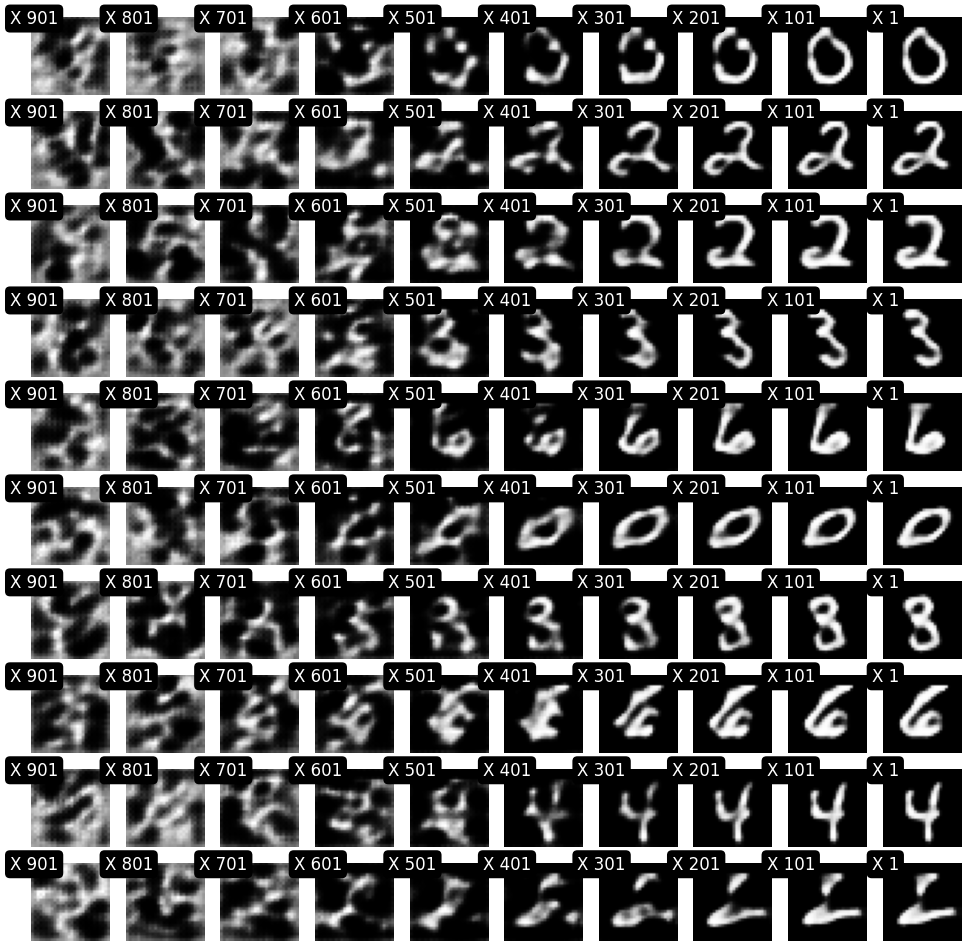

In [ ]:
show_sample2d(images, texts)


**Breakdown of Visualization:**  
- **Rows:** Each row corresponds to a different generated digit.  
- **Columns:** The columns represent the denoising process at different timesteps, starting from heavily noised images (left) to fully denoised images (right).  
- **Labels (X 901, X 801, ... X 1):** Indicate the timestep, where `X 901` represents early diffusion steps (more noise) and `X 1` represents the final denoised image.  

**Key Observations:**  
- The images become progressively clearer as the diffusion model removes noise step by step.  
- By timestep `X 1`, the digits are fully reconstructed, closely resembling real MNIST digits.  


In [36]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import torch

def visualize_diffusion_grid(dm, autoencoder, n_samples=24, n_steps=1000):
    """
    Visualize diffusion in a grid for n_samples with fine-grained frame saving near t=0.

    Args:
        dm: DenoiseDiffusion instance.
        autoencoder: Trained autoencoder with encode/decode methods.
        n_samples: Number of samples to visualize (must fit in the grid).
        n_steps: Total diffusion steps.
    """
    # Set the grid dimensions
    rows, cols = 4, 6
    assert n_samples == rows * cols, "Number of samples must match the grid size (rows * cols)."

    # Dynamically set the GIF path in the SAVE_DIR
    gif_path = f"{Config.SAVE_DIR}/grid_diffusion3.gif"

    device = Config.DEVICE
    fig, axes = plt.subplots(rows, cols, figsize=(15, 8))  # Adjust grid size
    ims = []  # For storing animation frames

    xt_list = [torch.randn((1, 1, 8, 8), device=device) for _ in range(n_samples)]  # Initialize random noise

    for t in tqdm(reversed(range(n_steps))):
        # Generate the next denoised state for all samples
        xt_list_next = [dm.p_sample(xt, torch.tensor([t]).to(device)) for xt in xt_list]
        xt_list = xt_list_next

        # Save frames at adaptive intervals
        if (t > 150 and t % 40 == 0) or (t <= 150 and t % 3 == 0) or t == 0:
            # fig.suptitle(f"Denoising Step {t}", fontsize=16)  # Dynamic title for the figure
            ims_row = []
            for idx, xt in enumerate(xt_list):
                # Decode each latent representation
                xt_reshaped = xt.view(1, -1)  # Flatten for decoder input
                xt_decoded = autoencoder.decoder(xt_reshaped).view(28, 28).to("cpu").detach()

                # Determine subplot position
                row, col = divmod(idx, cols)
                ax = axes[row][col]
                im = ax.imshow(xt_decoded, cmap="gray", animated=True)
                # ax.set_title(f"Step {t}" if row == 0 else "")  # Only show steps on the top row
                ax.axis("off")
                ims_row.append(im)

            ims.append(ims_row)

    # Create and save the GIF
    ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True, repeat_delay=1000)
    ani.save(gif_path, writer="imagemagick" if "imagemagick" in animation.writers else "pillow")
    print(f"GIF saved to {gif_path}")

# Call the function
visualize_diffusion_grid(dm, autoencoder, n_samples=24, n_steps=1000)


1000it [03:36,  4.61it/s]


GIF saved to /content/drive/My Drive/AI/Projects/diffusion mnist/models/grid_diffusion3.gif


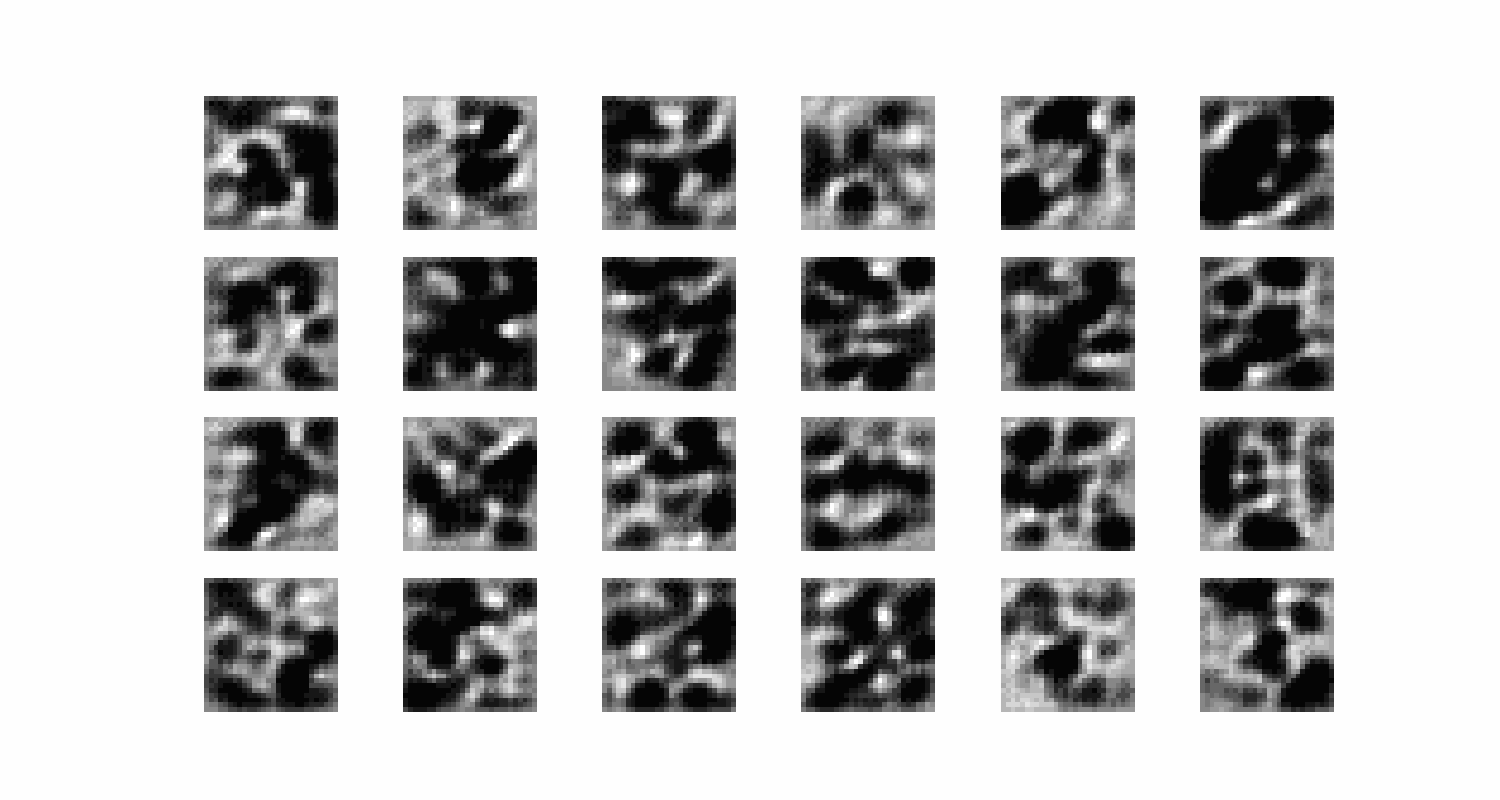

In [6]:
from IPython.display import Image
from IPython.display import display

gif_path = f"{Config.SAVE_DIR}/grid_diffusion3.gif"

# Display the GIF
display(Image(filename=gif_path))
